# SuperCon Dataset: ALIGNN Model Exploration
---

This is a notebook contining some of my initial experiments of using the [ALIGNN graph convolutional network](https://www.nature.com/articles/s41524-021-00650-1) to infer critical temperature in the SuperCon dataset. The source code for ALIGNN can be found here:



### Dependencies:

To run this notebook you will need to run `pip3 install <dependency>` for all of the packages listed below. These dependencies should be preinstalled in this project's associated Docker container:

In [25]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import tqdm
import os
#import torch
#import alignn

### Datasets:
Download each of the following and configure the path variables below:

* [Tc SuperCon Dataset (CSV)](https://github.com/vstanev1/Supercon).
* [Periodic Table of Elements (CSV)](https://gist.github.com/GoodmanSciences/c2dd862cd38f21b0ad36b8f96b4bf1ee)

In [26]:
SUPERCON_CSV = '/media/colin/Shared/colin/git/materials-ml/\
jupyter/supercond-exploration/data/Supercon-master/Supercon_data.csv'

PTABLE_CSV = '/media/colin/Shared/colin/git/materials-ml/\
jupyter/supercond-exploration/data/PTable/PeriodicTable.csv'

### API Keys:

To run this notebook, you will need to obtain a [Materials Project API key](https://materialsproject.org/api). This notebook assumes it is stored in the environment variable 'MP_API_KEY', which is loaded below. You can also set it by modifying the python code below, just be sure that you *never commit code that exposes an API key*.

If you use a python virtualenv, the best way to set this is to add the line 
```
export MP_API_KEY=xxxxxxxxxxxxxx
```

at the end of the `env/bin/activete` script.


In [27]:
MP_API_KEY = os.environ['MP_API_KEY']

## Load & Preprocess Data:

In [28]:
# load data into pandas dataframe:
supercon_df = pd.read_csv(SUPERCON_CSV)

# separate out known T_c from unknown T_c data:
known_tc = (supercon_df.Tc != 0)
supercon_df['KnownTc'] = known_tc

In [29]:
supercon_df # render in notebook

,name,Tc,KnownTc
0,Ba0.4K0.6Fe2As2,31.20,True
1,Ca0.4Ba1.25La1.25Cu3O6.98,40.10,True
2,Mo0.39Ru0.61,6.90,True
3,Tm4Os6Sn19,1.10,True
4,Nd1Bi0.99Pb0.01S2F0.3O0.7,4.85,True
...,...,...,...
16409,Al4C3,0.00,False
16410,Nb0.96Ta0.04,8.87,True
16411,Pb2Sr2Ho0.5Ca0.5Cu2.982Al0.018O8,63.60,True
16412,Yb0.5Pr0.5Ba2Cu3O6.9,34.80,True


In [30]:
ptable_df = pd.read_csv(PTABLE_CSV)
ptable_df # render in notebook

,AtomicNumber,Element,Symbol,AtomicMass,NumberofNeutrons,NumberofProtons,NumberofElectrons,Period,Group,Phase,...,FirstIonization,Density,MeltingPoint,BoilingPoint,NumberOfIsotopes,Discoverer,Year,SpecificHeat,NumberofShells,NumberofValence
0,1,Hydrogen,H,1.007,0,1,1,1,1.0,gas,...,13.5984,0.000090,14.175,20.28,3.0,Cavendish,1766.0,14.304,1,1.0
1,2,Helium,He,4.002,2,2,2,1,18.0,gas,...,24.5874,0.000179,NaN,4.22,5.0,Janssen,1868.0,5.193,1,NaN
2,3,Lithium,Li,6.941,4,3,3,2,1.0,solid,...,5.3917,0.534000,453.850,1615.00,5.0,Arfvedson,1817.0,3.582,2,1.0
3,4,Beryllium,Be,9.012,5,4,4,2,2.0,solid,...,9.3227,1.850000,1560.150,2742.00,6.0,Vaulquelin,1798.0,1.825,2,2.0
4,5,Boron,B,10.811,6,5,5,2,13.0,solid,...,8.2980,2.340000,2573.150,4200.00,6.0,Gay-Lussac,1808.0,1.026,2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,114,Flerovium,Fl,289.000,175,114,114,7,14.0,artificial,...,NaN,NaN,NaN,NaN,NaN,NaN,1999.0,NaN,7,4.0
114,115,Moscovium,Mc,288.000,173,115,115,7,15.0,artificial,...,NaN,NaN,NaN,NaN,NaN,NaN,2010.0,NaN,7,5.0
115,116,Livermorium,Lv,292.000,176,116,116,7,16.0,artificial,...,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,7,6.0
116,117,Tennessine,Ts,295.000,178,117,117,7,17.0,artificial,...,NaN,NaN,NaN,NaN,NaN,NaN,2010.0,NaN,7,7.0


## Classify Superconductors by Family

In [31]:
import re

def build_formula_regex(elements):
    """ builds a formula parsing regex """
    mass_re = '([0-9]*\.[0-9]+|[0-9]+)'
    elem_re = '(' + '|'.join(elements) + ')'
    return re.compile(elem_re + mass_re)

def parse_formula_tokens(formula, regex):
    """ parses a checmical formula consisting of <elem><mass> pairs"""
    tokens = []
    for match in regex.finditer(formula):
        if match.group(1):
            tokens.append((match.group(1), float(match.group(2))))
        else:
            # assume 1.0 if no mass term:
            tokens.append((match.group(1), 1.0))
    return tokens

def make_formula_vector(tokens, elements):
    v = np.zeros(len(elements))
    for t in tokens:
        v[elements.index(t[0])] += t[1]
    return v

In [32]:
elements = [ e.strip() for e in ptable_df.Symbol if e ]
form_re = build_formula_regex(elements)
data_idx = supercon_df.KnownTc


# format data tokens as: [(element, #), ...], (<base formula>, T_c)
dataset_tokens = [ 
    (parse_formula_tokens(form, form_re), (form, tc)) 
    for form, tc in zip(supercon_df.name[data_idx],
                    supercon_df.Tc[data_idx])
]

metals_set = set([ 'Sc', 'Ti', 'V', 'Ni', 
           'Cu','Zn', 'Pb', 'Zr', 'Nb', 
           'Mo', 'Pd', 'Ag', 'In', 'Sn',
           'Ir', 'Pt', 'Au', 'Hg', 'Pb' ])

cuprate_set = []
iron_based_set = []
elemental_set = []
metallic_alloy_set = []
other_set = []

for item in dataset_tokens:
    elems = list(t[0] for t in item[0])
    
    # classify elementals:
    if len(elems) <= 1:
        elemental_set.append(item)
        
    # classify cuprates:
    elif ('Cu' in elems):
        cuprate_set.append(item)
        
    # classify iron-based:
    elif ('Fe' in elems):
        iron_based_set.append(item)
    
    # classify metallic alloy
    elif (set(elems) | metals_set):
        metallic_alloy_set.append(item)
        
    # classify as other:
    else:
        other_set.append(item)

# construct as a dict of superconductor families:
families = {
    'Elemental' : elemental_set,
    'Metallic & Alloy' : metallic_alloy_set,
    'Iron-Based' : iron_based_set,
    'Cuprate' : cuprate_set,
}

## Visualize Dataset by Family

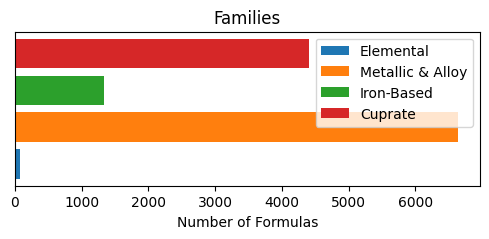

In [33]:
plt.figure(figsize=(6,2))
for x, (k, v) in enumerate(families.items()):
    plt.barh(x, len(v), label=k)
plt.legend()
plt.gca().set_yticks([])
plt.title('Families')
plt.xlabel('Number of Formulas')
plt.show()

*Notes:* The metallic and alloy family seems like a reasonable starting point, since I can easily infer the base unit cell structures and dope them accordingly. I will also need to perform relaxation within a small neighborhood of the defects to optimize the structure.

### Example of Alloy Structure Relaxation:

In order to convert all of the alloys into a crystal structure, I will first need to find the "base" unit cells of the material and expand it to form a pristine supercell of sufficient size. I will then need to determine the optimal dopant configuration for the supercell using (efficient) relaxation calculations. I will explore some of ASE's relaxation functionality in this section.

In [43]:
from ase.build import bulk, find_optimal_cell_shape, make_supercell
from ase.visualize import view
import numpy as np


# Construc a bulk Si supercell:
si = bulk('Si', 'diamond')
si_supercell = make_supercell(si, 2*np.eye(3))

si_supercell[0].symbol='Ce'

In [39]:
# calc.set(xc = calc_step)

if optimizer_type == 'QuasiNewton':
    relax = optimize.QuasiNewton(superCellDefect)
elif optimizer_type == 'BFGS':
    relax = optimize.BFGS(superCellDefect)
elif optimizer_type == 'LBFGS':
    relax = optimize.BFGSLineSearch(superCellDefect)
elif optimizer_type == 'GPMin':
    relax = optimize.GPMin(superCellDefect)
elif optimizer_type == 'FIRE':
    relax = optimize.FIRE(superCellDefect)
elif optimizer_type == 'MDMin':
    relax = optimize.MDMin(superCellDefect)
else:
    relax = optimize.QuasiNewton(superCellDefect)

relax.run(fmax = 0.05)

potential_current = superCellDefect.get_potential_energy()

ModuleNotFoundError: No module named 'gpaw'

## ALIGNN stuff

In [ ]:
from alignn.models.alignn import ALIGNN, ALIGNNConfig
import torch

output_features =  1
filename = 'temp/checkpoint_3.pt'
device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")

model = ALIGNN(ALIGNNConfig(name="alignn", output_features=output_features))
model.load_state_dict(torch.load(filename, map_location=device)["model"])
model.eval()